# Denoising / Diffusion

First we import some libaries, load the images and plot some of the images. 

In [23]:
import jax
import jax.numpy as jnp
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import flax
from flax import linen as nn    
import optax
from jax import random

In [12]:
IMG_PATH = "wikiart/Abstract_Expressionism"

# iterate over dir and get list of files
img_paths = pd.Series(os.listdir(IMG_PATH))
img_paths = img_paths[img_paths.str.contains(".jpg")].reset_index(drop=True)
imgs = []

# read 100 images
for i in range(100):
    img = plt.imread(os.path.join(IMG_PATH, img_paths[i]))
    imgs.append(img)

In [13]:
size = 64
imgs_resized = []
for img in imgs:
    img_resized = jax.image.resize(img, (size, size, 3), method="nearest")
    imgs_resized.append(img_resized)

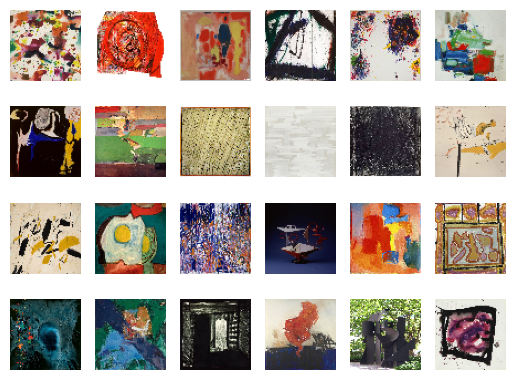

In [14]:
fig, axs = plt.subplots(4, 6)
for i in range(4):
    for j in range(6):
        axs[i, j].imshow(imgs_resized[i*6+j])
        axs[i, j].axis("off")

plt.show()

In [24]:

class Encoder(nn.Module):
  """VAE Encoder."""

  latents: int

  @nn.compact
  def __call__(self, x):
    x = nn.Dense(500, name='fc1')(x)
    x = nn.relu(x)
    mean_x = nn.Dense(self.latents, name='fc2_mean')(x)
    logvar_x = nn.Dense(self.latents, name='fc2_logvar')(x)
    return mean_x, logvar_x


class Decoder(nn.Module):
  """VAE Decoder."""

  @nn.compact
  def __call__(self, z):
    z = nn.Dense(500, name='fc1')(z)
    z = nn.relu(z)
    z = nn.Dense(784, name='fc2')(z)
    return z


class VAE(nn.Module):
  """Full VAE model."""

  latents: int = 20

  def setup(self):
    self.encoder = Encoder(self.latents)
    self.decoder = Decoder()

  def __call__(self, x, z_rng):
    mean, logvar = self.encoder(x)
    z = reparameterize(z_rng, mean, logvar)
    recon_x = self.decoder(z)
    return recon_x, mean, logvar

  def generate(self, z):
    return nn.sigmoid(self.decoder(z))


def reparameterize(rng, mean, logvar):
  std = jnp.exp(0.5 * logvar)
  eps = random.normal(rng, logvar.shape)
  return mean + eps * std


def model(latents):
  return VAE(latents=latents)

In [25]:
def train_step(optimizer, batch, rng):
  def loss_fn(params):
    recon_x, mean, logvar = model.apply({'params': params}, batch, rng)
    recon_loss = jnp.sum(jnp.square(batch - recon_x), axis=1)
    kl_loss = -0.5 * jnp.sum(1 + logvar - jnp.square(mean) - jnp.exp(logvar), axis=1)
    loss = jnp.mean(recon_loss + kl_loss)
    return loss, (recon_x, mean, logvar)
  grad_fn = jax.value_and_grad(loss_fn)
  loss, grad = grad_fn(optimizer.target)
  optimizer = optimizer.apply_gradient(grad)
  return optimizer, loss

def train(data, rng, latents, num_epochs, batch_size, learning_rate):
  rng, init_rng = random.split(rng)
  num_batches = data.shape[0] // batch_size
  model_def = model(latents)
  _, initial_params = model_def.init(init_rng, data, rng)
  optimizer = optax.adam(learning_rate).init(initial_params)
  for epoch in range(num_epochs):
    rng, epoch_rng = random.split(rng)
    for i in range(num_batches):
      batch = data[i * batch_size:(i + 1) * batch_size]
      rng, batch_rng = random.split(rng)
      optimizer, loss = train_step(optimizer, batch, batch_rng)
      if i % 100 == 0:
        print(f'Epoch {epoch}, Batch {i}, Loss {loss}')
  return optimizer


In [26]:
n_latents = 20
data = np.array(imgs_resized).reshape(-1, 64*64*3)
data = data / 255.0

rng = random.PRNGKey(0)
rng, key = random.split(rng)

opt = train(data, key, n_latents, 10, 64, 1e-3)

# sample from the model

ValueError: not enough values to unpack (expected 2, got 1)